#**PROJECT OVERVIEW**
---
The dataset used on this project can be found in the link below:
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

#**Library Import**
---

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import FunctionTransformer
import re
import emoji

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras
from sklearn.pipeline import Pipeline, FeatureUnion

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#**Data Loading**
---


In [44]:
header = ['ID', 'Topic', 'Sentiment', 'Tweet']
df = pd.read_csv(
    'https://raw.githubusercontent.com/comradeftj/Datsets/refs/heads/main/twitter_training.csv',
    names=header,
    header=None
)
df = df.head(10000)
df.head()

,ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#**EDA**
---

##**1. Data Information**
---

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         10000 non-null  int64 
 1   Topic      10000 non-null  object
 2   Sentiment  10000 non-null  object
 3   Tweet      9888 non-null   object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


##**2. Missing Values Detection**
---

In [46]:
df.isnull().sum()

ID             0
Topic          0
Sentiment      0
Tweet        112
dtype: int64

##**3. Categorical Data Distribution**
---

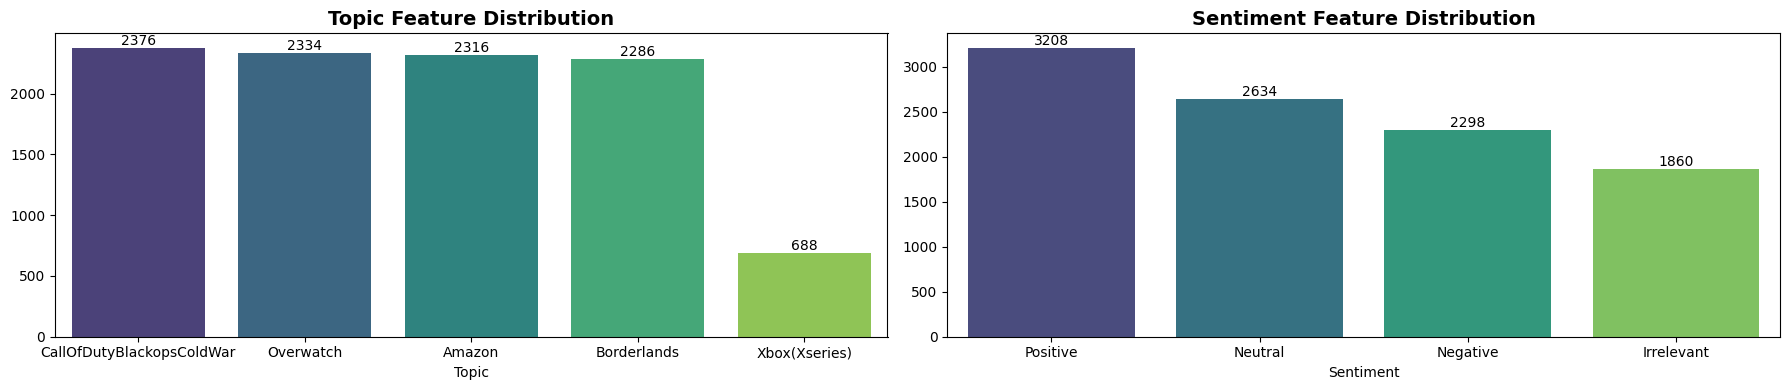

In [47]:
cols = ['Topic', 'Sentiment']

plt.figure(figsize=(18, 4))
for i, col in enumerate(cols):
  plt.subplot(1, 2, i+1)
  counts = df[col].value_counts()
  ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='viridis')
  for val in ax.containers:
    label = [v.get_height() for v in val]
    ax.bar_label(val, label=label, label_type='edge')
  plt.title(f'{col} Feature Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##**4. Text Word Count Distribution**
---

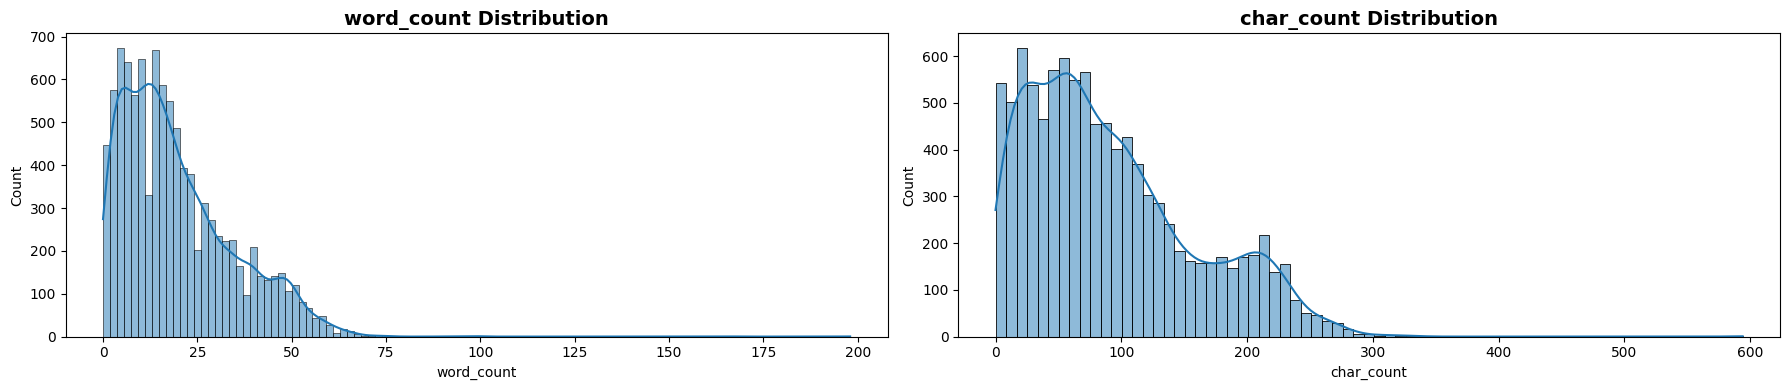

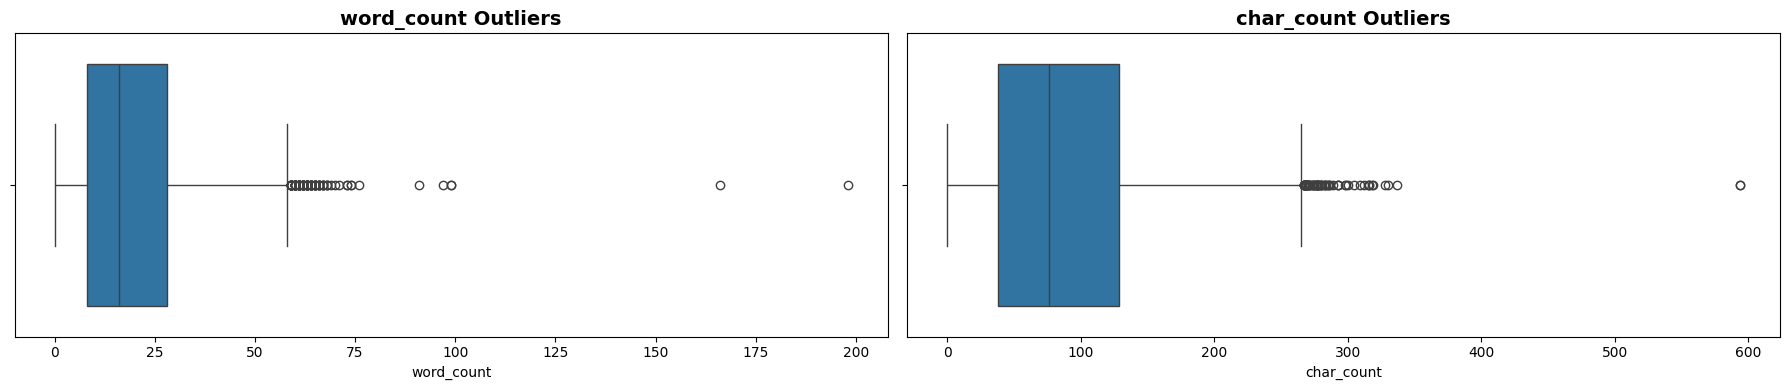

In [48]:
def word_count(text):
  if pd.isna(text):
    return 0
  text = text.strip(' ').split(' ')
  return (len(text))

def char_count(text):
  if pd.isna(text):
    return 0
  text = text.strip(' ').replace(' ', '')
  return len(text)

df['word_count'] = df['Tweet'].apply(word_count)
df['char_count'] = df['Tweet'].apply(char_count)
cols = ['word_count', 'char_count']

plt.figure(figsize=(18, 4))
for i, col in enumerate(cols):
  plt.subplot(1, 2, i+1)
  sns.histplot(df[col], kde=True)
  plt.title(f'{col} Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(' ')
plt.figure(figsize=(18, 4))
for i, col in enumerate(cols):
  plt.subplot(1, 2, i+1)
  sns.boxplot(x=df[col])
  plt.title(f'{col} Outliers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#**Pre-Processing**
---

##**1. Drop Irrelevant Data**
---

In [49]:
df = df.dropna()

df.head()

,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,11,43
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12,40
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10,41
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10,42
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12,46


Note: Tweets with the sentiment label 'Irrelevant' would be classed as 'Neutral', as whilst it is assumed that these tweets are irrelevant to the general topic (which is regarding games), it is neither negative nor positive, and as such, could be regarded as neutral sentiments

In [50]:
def replace_irrelevant(sentiment):
  if sentiment == 'Irrelevant':
    sentiment = 'Neutral'
    return sentiment
  return sentiment

df = df[df['Sentiment'] != 'Irrelevant']
df.head()

,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,11,43
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12,40
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10,41
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10,42
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12,46


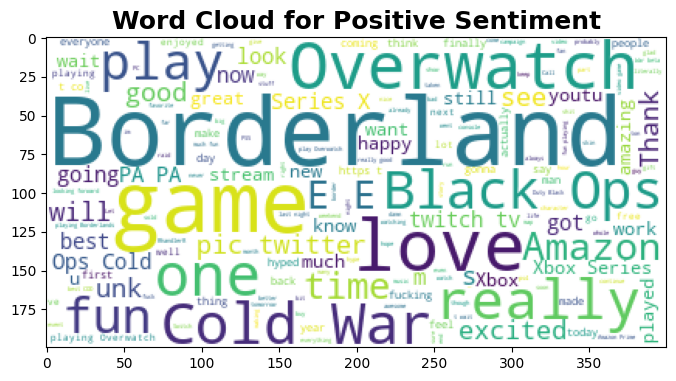

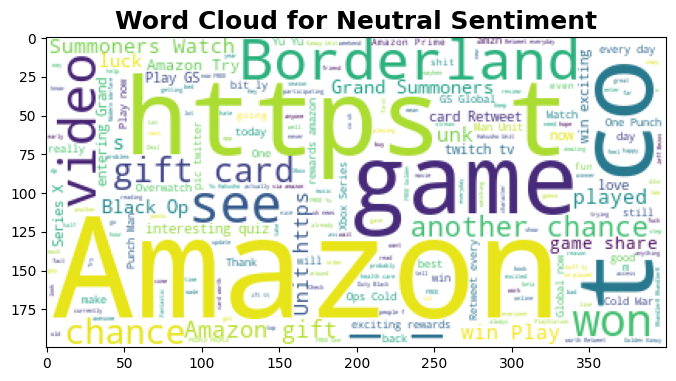

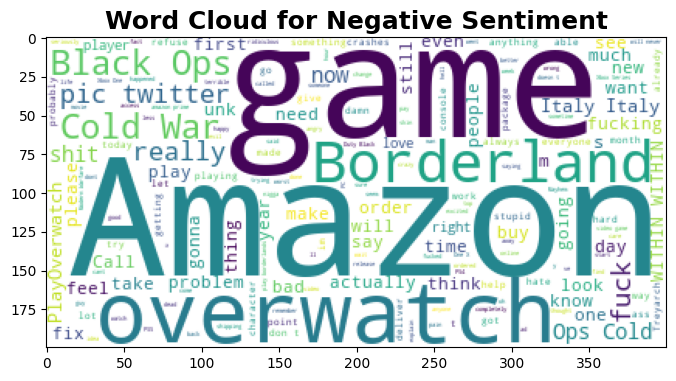

In [51]:
count = df['Sentiment'].unique()

for val in count:
  data = df[df['Sentiment'] == val]
  plt.figure(figsize=(8, 6))
  text = ''.join(data['Tweet'])
  wordcloud = WordCloud(background_color='white').generate(text)
  plt.imshow(wordcloud)
  plt.title(f'Word Cloud for {val} Sentiment', fontweight='bold', fontsize=18)
  plt.show()

##**2. Data Encoding**
---

In [52]:
def encode(sentiment):
  if sentiment == 'Positive':
    return 2
  elif sentiment == 'Negative':
    return 0
  elif sentiment == 'Neutral':
    return 1

df_new = df.copy()
df_new['Sentiment'] = df_new['Sentiment'].apply(encode)
df_new.head()

,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,11,43
1,2401,Borderlands,2,I am coming to the borders and I will kill you...,12,40
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10,41
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,10,42
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,12,46


In [53]:
df['Sentiment'] = df['Sentiment'].apply(encode)
df.head(3)

,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,11,43
1,2401,Borderlands,2,I am coming to the borders and I will kill you...,12,40
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10,41


##**3. Removing Punctuations & Emoji Handling**
---

In [ ]:
def cleanse(words):
  words = words.strip(" ")
  words = emoji.demojize(words).replace(':', '')
  words = words.replace('_', ' ')
  words = words.lower()
  words = re.sub(r'[?|$|.|!_:"\')(-+,]', '', words)
  words = re.sub(r'\d+', '', words)
  words = re.sub(r"\b[a-zA-Z]\b", "", words)
  words = re.sub('\s+',' ', words)
  return words

df_new['Tweet'] = df_new['Tweet'].apply(cleanse)

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\louis\AppData\Local\Temp\ipykernel_2948\3727428643.py:9: SyntaxWarning: invalid escape sequence '\s'
  words = re.sub('\s+',' ', words)


In [ ]:
df_new.head()

,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,2,im getting on borderlands and will murder you ...,11,43
1,2401,Borderlands,2,am coming to the borders and will kill you all,12,40
2,2401,Borderlands,2,im getting on borderlands and will kill you all,10,41
3,2401,Borderlands,2,im coming on borderlands and will murder you all,10,42
4,2401,Borderlands,2,im getting on borderlands and will murder you ...,12,46


##**4. Tokenizing**
---

In [ ]:
df_new['Tweet'] = df_new['Tweet'].apply(nltk.word_tokenize)
df_new.head()

,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,2,"[im, getting, on, borderlands, and, will, murd...",11,43
1,2401,Borderlands,2,"[am, coming, to, the, borders, and, will, kill...",12,40
2,2401,Borderlands,2,"[im, getting, on, borderlands, and, will, kill...",10,41
3,2401,Borderlands,2,"[im, coming, on, borderlands, and, will, murde...",10,42
4,2401,Borderlands,2,"[im, getting, on, borderlands, and, will, murd...",12,46


##**5. Stopword Removal**
---

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def delete_stopwords(words):
  filter_words = stopwords.words('english')

  data = []
  def myFunc(x):
    if x in filter_words:
      return False
    else:
      return True
  fit = filter(myFunc, words)
  for x in fit:
    data.append(x)
  return data

df_new['Tweet'] = df_new['Tweet'].apply(delete_stopwords)
df_new.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ID,Topic,Sentiment,Tweet,word_count,char_count
0,2401,Borderlands,2,"[im, getting, borderlands, murder]",11,43
1,2401,Borderlands,2,"[coming, borders, kill]",12,40
2,2401,Borderlands,2,"[im, getting, borderlands, kill]",10,41
3,2401,Borderlands,2,"[im, coming, borderlands, murder]",10,42
4,2401,Borderlands,2,"[im, getting, borderlands, murder]",12,46


##**6. Lemmatization & POS Tagging**
---

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

def pos_tagging(tags):
  if tags.startswith('J'):
    return 'a'
  elif tags.startswith('V'):
    return 'v'
  elif tags.startswith('N'):
    return 'n'
  elif tags.startswith('R'):
    return 'r'
  else:
    return 'n'

def lemmatize(words):
  lemma = WordNetLemmatizer()
  tags = pos_tag(words)
  lemmatized = [lemma.lemmatize(word, pos_tagging(tag)) for word, tag in tags]
  result = ' '.join(lemmatized)
  #print(result)
  #print(tags)
  return result

df_new['Tweet'] = df_new['Tweet'].apply(lemmatize)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
def apply_cleanse(series):
    return series.apply(cleanse)

def apply_tokenize(series):
    return series.apply(nltk.word_tokenize)

def apply_delete_stopwords(series):
    return series.apply(delete_stopwords)

def apply_lemmatize(series):
    return series.apply(lemmatize)

transformer_clean = FunctionTransformer(apply_cleanse, validate=False)
transformer_tokenize = FunctionTransformer(apply_tokenize, validate=False)
transformer_stopword = FunctionTransformer(apply_delete_stopwords, validate=False)
tranformer_lemma = FunctionTransformer(apply_lemmatize, validate=False)
transformer_vectorizer = FunctionTransformer(TfidfVectorizer)

vectorizer_pipe = Pipeline([
    #('text', text_data),
    ('cleaner', transformer_clean),
    ('tokenizer', transformer_tokenize),
    ('stopword_removal', transformer_stopword),
    ('lemma', tranformer_lemma),
    ('vectorizer', TfidfVectorizer())
])

##**7. Undersampling**
---

In [ ]:
vectorizer = TfidfVectorizer()

x = df_new['Tweet'].values.reshape(-1, 1)
y = df_new['Sentiment']

rus = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = rus.fit_resample(x, y)
print('Hasil Undersampling')
display(y_resampled.value_counts())

Hasil Undersampling


Sentiment
0    2282
1    2282
2    2282
Name: count, dtype: int64

##**8. Data Splitting & Vectorizing**
---

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

vectorizer = TfidfVectorizer()
vectorizer.fit(x_train.flatten())
x_train = vectorizer.transform(x_train.flatten())
x_test = vectorizer.transform(x_test.flatten())
x_tf_idf = vectorizer.transform(x_resampled.flatten())
print('\nHasil TF-IDF')
print(x_train)


Hasil TF-IDF
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 59681 stored elements and shape (5476, 6042)>
  Coords	Values
  (0, 142)	0.0787120814937392
  (0, 326)	0.21679242209614663
  (0, 688)	0.13972264585949593
  (0, 824)	0.16884284049482032
  (0, 1057)	0.2255476849715938
  (0, 1095)	0.20803715922069943
  (0, 1734)	0.24343627539379678
  (0, 1849)	0.15830433368364816
  (0, 2100)	0.09961774355272043
  (0, 2185)	0.2331961417045411
  (0, 2366)	0.32711519580559345
  (0, 2730)	0.24343627539379678
  (0, 2886)	0.18252360401165194
  (0, 3449)	0.21000131261175492
  (0, 3749)	0.24343627539379678
  (0, 3980)	0.2331961417045411
  (0, 3986)	0.18600554743515563
  (0, 4001)	0.16400189505871193
  (0, 4036)	0.1932613043367791
  (0, 4153)	0.20619212071620097
  (0, 4577)	0.19976117892249923
  (0, 4813)	0.20803715922069943
  (0, 5067)	0.2331961417045411
  (0, 5251)	0.1405397100913628
  (1, 1998)	0.7697411829782178
  :	:
  (5474, 3480)	0.43361689050777846
  (5474, 3745)	0.1774482508764961

In [ ]:
print(f'Ukuran input: {x_tf_idf.shape}')

Ukuran input: (6846, 6042)


In [ ]:
x_r = df['Tweet']
y_r = df['Sentiment']

# rus = RandomUnderSampler(random_state=42)
# x_resampled_r, y_resampled_r = rus.fit_resample(x_r, y_r)

x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_r, y_r, test_size=0.2, stratify=y_r, random_state=42)

In [ ]:
x_train_r

4964    My toilet handle has just broken off, so until...
5213    New season of 'The Lion' is now on Amazon we lit!
6250    Feds Crack Them Down on Their Fraud Scheme Mon...
6531    for little armys who just joined TF fandom, we...
464     Lil preview of a Maya drawing I've been chimin...
                              ...                        
8432              Wow, my Widowmaker recently has been A1
4152            Shit I would watch this if it was a movie
6934    You wth amazon, my album box still hasn'un t m...
6685                     If you like it, you'll regret it
5726    All of these price data would be surprising if...
Name: Tweet, Length: 6446, dtype: object

#**Modelling**
---

##**1. Creating Model**
---

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# One-hot encode target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Redefine and recompile the model
model_clf = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(x_train.shape[1],), activation='relu'),
    # Only takes input with values > 0
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_clf.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

d:\ai_ml\aiml_env\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###Neural Network Weight & Bias before training

In [ ]:
print('Weight & Bias before training:')
print('\n1. Hidden layer 1:')
display(model_clf.get_weights()[0:2])
print('\n2. Hidden layer 2:')
display(model_clf.get_weights()[2:4])
print('\n3. Output layer:')
display(model_clf.get_weights()[4:])

Weight & Bias before training:

1. Hidden layer 1:


[array([[ 0.00146504,  0.02133158, -0.01457223, ...,  0.0117666 ,
          0.03099573, -0.01745862],
        [-0.00694273, -0.02293585, -0.01427374, ...,  0.00624667,
         -0.02885802,  0.0203031 ],
        [-0.01260154, -0.00507952, -0.00986751, ...,  0.02279922,
         -0.01111548,  0.01709111],
        ...,
        [ 0.0001587 , -0.0246927 ,  0.01067271, ...,  0.00447519,
         -0.02938818, -0.02073259],
        [-0.01679115,  0.01212054, -0.02461748, ..., -0.00620319,
          0.02697051, -0.02882996],
        [ 0.02645557, -0.00677603, -0.00582317, ..., -0.02629874,
          0.00243793, -0.01369406]], shape=(6042, 128), dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.,


2. Hidden layer 2:


[array([[ 0.1573147 ,  0.12410317,  0.16304196, ...,  0.10766532,
         -0.1183451 , -0.06660698],
        [-0.00349537, -0.0309725 ,  0.09965484, ...,  0.1678287 ,
          0.07459874, -0.10156973],
        [-0.04664236,  0.09154405,  0.05847897, ..., -0.05314456,
         -0.03481869, -0.14776242],
        ...,
        [ 0.02052522, -0.09894815,  0.05974025, ..., -0.1730336 ,
          0.14210467, -0.03330997],
        [ 0.07225533, -0.13727503, -0.14850163, ..., -0.05816678,
         -0.12597099, -0.06572228],
        [-0.08316669,  0.10418217, -0.01870641, ...,  0.09588821,
          0.0403422 , -0.09338511]], shape=(128, 64), dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]


3. Output layer:


[array([[ 1.10831887e-01,  9.53188241e-02,  1.03425741e-01],
        [-1.03397980e-01,  2.56724834e-01, -1.29536331e-01],
        [-1.74045563e-05,  1.58221692e-01, -1.26461029e-01],
        [-7.17411935e-02,  1.70467764e-01, -2.09143013e-01],
        [ 6.19671047e-02,  2.74455309e-01,  6.30170405e-02],
        [-4.01510596e-02,  4.70594764e-02,  2.24410415e-01],
        [-4.13475335e-02,  2.27102220e-01, -1.43904060e-01],
        [ 4.72989976e-02,  1.13386124e-01,  2.43955433e-01],
        [ 1.04569286e-01,  2.39727437e-01, -7.78870583e-02],
        [-2.89491624e-01, -1.21858984e-01, -4.27494645e-02],
        [ 2.50760555e-01,  1.06264442e-01, -1.87020019e-01],
        [-1.65697977e-01, -4.81222570e-02,  1.39557630e-01],
        [-2.74586380e-02, -7.92757720e-02, -1.24240220e-02],
        [ 9.63261724e-02,  2.23286331e-01, -6.99694306e-02],
        [-8.49425793e-03, -2.29058862e-01,  2.47692227e-01],
        [ 1.58240736e-01, -1.58380881e-01,  1.65521979e-01],
        [-4.15458977e-02

##**2. Training**
---

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_clf.fit(
    x_train.toarray(),
    y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopper],
    verbose=2)

Epoch 1/10
137/137 - 77s - 560ms/step - accuracy: 0.5470 - loss: 1.0842 - val_accuracy: 0.7710 - val_loss: 1.0407
Epoch 2/10
137/137 - 7s - 52ms/step - accuracy: 0.8598 - loss: 0.8741 - val_accuracy: 0.8495 - val_loss: 0.7365
Epoch 3/10
137/137 - 6s - 46ms/step - accuracy: 0.9320 - loss: 0.5547 - val_accuracy: 0.8814 - val_loss: 0.5485
Epoch 4/10
137/137 - 5s - 35ms/step - accuracy: 0.9587 - loss: 0.3854 - val_accuracy: 0.8978 - val_loss: 0.4483
Epoch 5/10
137/137 - 4s - 30ms/step - accuracy: 0.9712 - loss: 0.2934 - val_accuracy: 0.9069 - val_loss: 0.3870
Epoch 6/10
137/137 - 4s - 29ms/step - accuracy: 0.9744 - loss: 0.2367 - val_accuracy: 0.9015 - val_loss: 0.3620
Epoch 7/10
137/137 - 4s - 33ms/step - accuracy: 0.9772 - loss: 0.1979 - val_accuracy: 0.9124 - val_loss: 0.3322
Epoch 8/10
137/137 - 4s - 30ms/step - accuracy: 0.9765 - loss: 0.1702 - val_accuracy: 0.9088 - val_loss: 0.3139
Epoch 9/10
137/137 - 5s - 34ms/step - accuracy: 0.9772 - loss: 0.1498 - val_accuracy: 0.9124 - val_los

###Neural Network Weight & Bias after training

In [ ]:
print('Weight & Bias after training:')
print('\n1. Hidden layer 1:')
display(model_clf.get_weights()[0:2])
print('\n2. Hidden layer 2:')
display(model_clf.get_weights()[2:4])
print('\n3. Output layer:')
display(model_clf.get_weights()[4:])

Weight & Bias after training:

1. Hidden layer 1:


[array([[-0.00945684,  0.06265344,  0.01444673, ..., -0.02558073,
          0.06868168, -0.05467854],
        [-0.05186797, -0.06136793, -0.06061349, ...,  0.05146526,
         -0.07195686, -0.0249109 ],
        [-0.00892782,  0.01838047,  0.00856279, ...,  0.01565536,
          0.0065437 ,  0.00546515],
        ...,
        [ 0.0001587 , -0.0246927 ,  0.01067271, ...,  0.00447519,
         -0.02938818, -0.02073259],
        [-0.01679115,  0.01212054, -0.02461748, ..., -0.00620319,
          0.02697051, -0.02882996],
        [ 0.02645557, -0.00677603, -0.00582317, ..., -0.02629874,
          0.00243793, -0.01369406]], shape=(6042, 128), dtype=float32),
 array([0.16115311, 0.1315182 , 0.10300753, 0.12196802, 0.21093133,
        0.15539399, 0.1856176 , 0.20740081, 0.09423288, 0.27028346,
        0.10871939, 0.12426441, 0.15076503, 0.18769407, 0.09205047,
        0.26499605, 0.20690547, 0.107454  , 0.11230204, 0.20472866,
        0.20902981, 0.15108746, 0.10984154, 0.18511377, 0.18612707,


2. Hidden layer 2:


[array([[-0.10191073, -0.14582077, -0.09114847, ..., -0.07242257,
         -0.5233925 , -0.3140109 ],
        [-0.24117965,  0.08489491,  0.06702554, ..., -0.02553075,
         -0.28890905, -0.27365255],
        [-0.27207458,  0.23537141,  0.05752486, ..., -0.24383248,
         -0.37136415, -0.29559976],
        ...,
        [-0.16566996, -0.38701525, -0.1521371 , ..., -0.41376713,
          0.4074671 , -0.18376929],
        [-0.21484815, -0.18916257, -0.3863391 , ..., -0.31120872,
         -0.54730415, -0.33854768],
        [-0.30818498, -0.17282063, -0.26503676, ..., -0.10092909,
         -0.24489738, -0.32761717]], shape=(128, 64), dtype=float32),
 array([-0.21601667, -0.07204576, -0.1238848 , -0.09974776, -0.12940043,
        -0.12060407, -0.10174836, -0.13924262, -0.13114117, -0.13541344,
        -0.08477756, -0.11009186, -0.17859551, -0.1201153 ,  0.04247635,
        -0.08491533, -0.14379366, -0.13854268, -0.14050236, -0.13697441,
        -0.02953457,  0.1031705 , -0.07062512, -0


3. Output layer:


[array([[ 0.14881623,  0.04923666,  0.11493962],
        [-0.27828792,  0.46824908, -0.28747353],
        [-0.07249014,  0.26907194, -0.19543624],
        [-0.19331518,  0.3297615 , -0.31474063],
        [-0.00783078,  0.37459132,  0.00765122],
        [-0.10108654, -0.03426076,  0.34263027],
        [-0.16303326,  0.3882669 , -0.25387877],
        [ 0.01048696,  0.06459735,  0.3208263 ],
        [ 0.08490433,  0.31403828, -0.14199659],
        [-0.36561412, -0.13137758,  0.03389035],
        [ 0.42576778,  0.01693011, -0.31837705],
        [-0.253996  , -0.10466369,  0.25897083],
        [ 0.01675694, -0.16101544,  0.03116147],
        [ 0.05498382,  0.32038158, -0.14615305],
        [-0.3155395 , -0.6685203 ,  0.6986307 ],
        [ 0.33642796, -0.36971268,  0.22238187],
        [-0.10785543,  0.24713345,  0.13206317],
        [-0.14113711,  0.20968434, -0.1592447 ],
        [-0.1330394 ,  0.13077095,  0.3278809 ],
        [-0.18466234,  0.16794999,  0.01564438],
        [ 0.24548408

##**3. Model Testing**
---

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       456
           1       0.89      0.95      0.92       457
           2       0.91      0.91      0.91       457

    accuracy                           0.92      1370
   macro avg       0.92      0.92      0.92      1370
weighted avg       0.92      0.92      0.92      1370



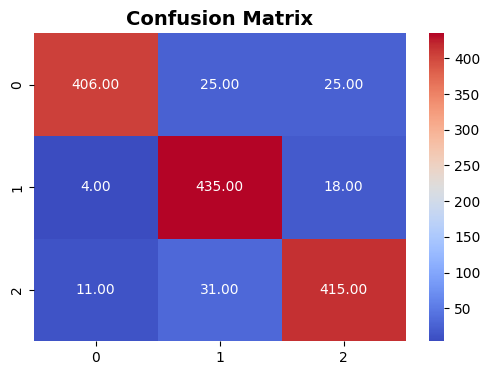

In [ ]:
y_pred = model_clf.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()

##**4. Model Download**
---

In [ ]:
import os
import joblib

path_curr = os.path.abspath("NLP.ipynb")

In [ ]:
joblib.dump(model_clf, os.path.join(path_curr, '..', '..', 'model', 'nlp_nn.pkl'))
joblib.dump(cleanse, os.path.join(path_curr, '..', '..', 'model', 'punctuation_clean.pickle'))
joblib.dump(nltk.word_tokenize, os.path.join(path_curr, '..', '..', 'model', 'tokenizer.pickle'))
joblib.dump(delete_stopwords, os.path.join(path_curr, '..', '..', 'model', 'stopwords.pickle'))
joblib.dump(lemmatize, os.path.join(path_curr, '..', '..', 'model', 'lemma.pickle'))
joblib.dump(vectorizer, os.path.join(path_curr, '..', '..', 'model', 'vectorizer.pickle'))

['d:\\ai_ml\\streamlit_project\\notebook\\NLP.ipynb\\..\\..\\model\\vectorizer.pickle']

In [ ]:
joblib_model = joblib.load(os.path.join(path_curr, '..', '..', 'model', 'nlp_nn.pkl'))
cleaner = joblib.load(os.path.join(path_curr, '..', '..', 'model', 'punctuation_clean.pickle'))
tokenizer_dld = joblib.load(os.path.join(path_curr, '..', '..', 'model', 'tokenizer.pickle'))
stopword = joblib.load(os.path.join(path_curr, '..', '..', 'model', 'stopwords.pickle'))
lemma = joblib.load(os.path.join(path_curr, '..', '..', 'model', 'lemma.pickle'))
vectorizer_dld = joblib.load(os.path.join(path_curr, '..', '..', 'model', 'vectorizer.pickle'))

trial = pd.DataFrame({
    'Tweet': ['This is bad, I think it would fail']
})

trial['Tweet'] = trial['Tweet'].apply(cleaner)
trial['Tweet'] = trial['Tweet'].apply(tokenizer_dld)
trial['Tweet'] = trial['Tweet'].apply(stopword)
trial['Tweet'] = trial['Tweet'].apply(lemma)
trial_vectorized = vectorizer_dld.transform(trial['Tweet'])
joblib_model.predict(trial_vectorized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


array([[0.9109638 , 0.04565404, 0.04338221]], dtype=float32)